## Imports

In [1]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.models import Input, Model
from keras.models import load_model

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import random

import seaborn as sns
sns.set(style='darkgrid')

import sklearn
import sklearn.datasets
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc, accuracy_score

import sys

/Users/WillLacey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data

In [2]:
try:
    df = pd.read_csv('chess_fen_data.csv') # read in the csv file
    print("Succeeded to Open File.\n")
    print(df.info()) 
    
except IOError:
    print("Failed to Open Files. Quitting Program.")
    sys.exit

Succeeded to Open File.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 2 columns):
Evaluation    310 non-null float64
FEN           310 non-null object
dtypes: float64(1), object(1)
memory usage: 4.9+ KB
None


In [3]:
df[0:5]

,Evaluation,FEN
0,0.2,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...
1,0.2,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
2,0.4,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...
3,0.3,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...
4,0.2,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...


## Converting Fen into Custom Evaluation Metric

In [4]:
custom_representations = []
for fen in df['FEN']:
    data = []
#     rank = []
    additional_info_index = 0
    for c in fen:
        if c == 'p':
#             rank.append(-1)
            data.append(-1)
        elif c == 'r':
#             rank.append(-5)
            data.append(-5)
        elif c == 'n':
#             rank.append(-3)
            data.append(-3)
        elif c == 'b':
#             rank.append(-3.5)
            data.append(-3.5)
        elif c == 'q':
#             rank.append(-9)
            data.append(-9)
        elif c == 'k':
#             rank.append(-100)
            data.append(-100)
        elif c == 'P':
#             rank.append(1)
            data.append(1)
        elif c == 'R':
#             rank.append(5)
            data.append(5)
        elif c == 'N':
#             rank.append(3)
            data.append(3)
        elif c == 'B':
#             rank.append(3.5)
            data.append(3.5)
        elif c == 'Q':
#             rank.append(9)
            data.append(9)
        elif c == 'K':
#             rank.append(100)
            data.append(100)
        elif c == '/':
#             data.append(rank)
#             rank = []
            pass
        elif c == ' ':
            additional_info_index += 1
#             data.append(rank)
            
#             additional_info = []
            whitespace_count = 0
            buffer = ''
            
            while additional_info_index < len(fen):
                if fen[additional_info_index] != ' ':
                    buffer += fen[additional_info_index]
                else:
                    if whitespace_count == 0: # Who's turn it is
                        if buffer == 'w':
#                             additional_info.append(1)
                            data.append(1)
                        else:
#                             additional_info.append(-1)
                            data.append(-1)
                    elif whitespace_count == 1: # Who can castle and where
                        white_king_side_castle = 0
                        white_queen_side_castle = 0
                        black_king_side_castle = 0
                        black_queen_side_castle = 0
                        for c2 in buffer:
                            if c2 == 'K':
                                white_king_side_castle = 1
                            elif c2 == 'Q':
                                white_queen_side_castle = 1
                            elif c2 == 'k':
                                black_king_side_castle = 1
                            elif c2 == 'q':
                                black_queen_side_castle = 1
                        data.append(white_king_side_castle)
                        data.append(white_queen_side_castle)
                        data.append(black_king_side_castle)
                        data.append(black_queen_side_castle)
                        
                    elif whitespace_count == 2: # Can an en passant occur and where
                        pass
                    elif whitespace_count == 3: # How many turns since capture or pawn advance
                        pass
                    elif whitespace_count == 4: # What turn is it
                        pass
                    
                    whitespace_count += 1
                    buffer = ''
                additional_info_index += 1
#             data.append(additional_info)
            break
            
        else:
            c = int(c)
            for i in range(c):
#                 rank.append(0)
                data.append(0)
        additional_info_index += 1
        
    custom_representations.append(data)

print(df['FEN'][0])
print(custom_representations[0])

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
[-5, -3, -3.5, -9, -100, -3.5, -3, -5, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3.5, 9, 100, 3.5, 3, 5, 1, 1, 1, 1, 1]


## Doubling the data by flipping color and mirroring board

In [5]:
new_custom_representations = []
for cr in custom_representations:
    new_cr = []
    new_row = []
    
    count = 63
    while count >= 0:
        if (count+1) % 8 == 0 and (count+1) != (64):
            new_row.reverse()
            new_cr.extend(new_row)
            new_row = []
        new_row.append( -1 * cr[count])
        count -= 1
    new_row.reverse()
    new_cr.extend(new_row)

    new_cr.append(-1 * cr[64])
    new_cr.append(cr[67])
    new_cr.append(cr[68])
    new_cr.append(cr[65])
    new_cr.append(cr[66])
    
    new_custom_representations.append(new_cr)
    
combined_custom_representations = custom_representations
combined_custom_representations.extend(new_custom_representations)
len(combined_custom_representations)

620

Let's quickly extract the evaluations from the dataframe, then double the entries

In [6]:
evaluations = []
for val in df['Evaluation']:
    evaluations.append(val)

new_evaluations = []
for val in df['Evaluation']:
    evaluations.append(-1 * val) 

combined_evaluations = evaluations
combined_evaluations.extend(new_evaluations)
len(combined_evaluations)

620

Okay, let's normalize the chessboard and evaluation values from -1 to 1

In [7]:
for rep in combined_custom_representations:
    for i in range(64):
        rep[i] = rep[i] / 100

for i in range(len(combined_evaluations)):
    combined_evaluations[i] = combined_evaluations[i] / 100
    
combined_custom_representations[0][0:8]

[-0.05, -0.03, -0.035, -0.09, -1.0, -0.035, -0.03, -0.05]

## Preparing the Dataset

These are some useful functions for preparing the sklearn dataset

In [8]:
def shuffle(data, seed=0):
    """Shuffles the data given a random seed"""
    random.seed(seed)
    random.shuffle(data)
    return data

def split(data, percentage, number_of_classes=1):
    """Splits data and target into training and testing data based off the split percentage"""

    train = []
    test = []
    number_per_class = int(len(data) / number_of_classes)
    
    for i in range(number_of_classes):
        start = i * number_per_class
        index_split = start + int(percentage * number_per_class)
        end = (i * number_per_class) + number_per_class
        
        train.extend(data[start:index_split])
        test.extend(data[index_split:end])
        
    return train, test

Next, shuffling and splitting the data

In [9]:
# Shuffle Data
random_seed = random.randint(0, 1000) # Create a random seed for shuffling
shuffled_custom = shuffle(combined_custom_representations, random_seed)
shuffled_eval = shuffle(combined_evaluations, random_seed)

# Split Data
percentage = 9/10 # 90 10 split
data_train, data_test = split(shuffled_custom, percentage)
target_train, target_test = split(shuffled_eval, percentage)

Create Sklearn dataset

In [10]:
ds = sklearn.datasets.base.Bunch(
    X_train = np.array(data_train),
    X_test = np.array(data_test),
    y_train = np.array(target_train),
    y_test = np.array(target_test)
)
ds.X_train[0]

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.01 , -1.   , -0.01 ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.05 ,  0.   ,  0.   ,  0.   ,  0.01 ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -0.035,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.01 ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
       -1.   ,  0.   ,  0.   ,  0.   ,  0.   ])

Maybe we should delete data that is no longer needed. I don't know man

In [11]:
del data_train
del data_test
del target_train
del target_test
del shuffled_custom
del shuffled_eval

del combined_custom_representations
del custom_representations
del new_custom_representations

del combined_evaluations
del evaluations
del new_evaluations

## Modeling

In [12]:
def network_fit(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=16, patience=5, verbose=0):
    """Fits data to a neural network using a specified epoch count and batch size; also 
    utilizes a specified data expansion"""
    history = nn.fit(x=X_train, 
                     y=y_train, 
                     validation_data=(X_test, y_test), 
                     epochs=epochs, 
#                      steps_per_epoch=int(len(X_train)/batch_size),
                     batch_size=batch_size, 
                     verbose=verbose, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]   
    )
    
    return history

def network_predict(nn, X_test, y_test):
    """Returns an accuracy for a neural network, a confusion matrix, and ROC data"""
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba, 3)
#     acc = mt.accuracy_score(y_test, yhat)
#     fpr, tpr, _ = roc_curve(y_test.flatten(), yhat_proba.flatten())
#     roc_auc = auc(fpr, tpr)
    return yhat

def network_plot(history):    
    """Visualizes the performance of the training and validation sets per epoch"""
    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

def network_summarize(net, X_test, y_test, title_text=''):
    """This function visualizes the confusion matrix"""
    plt.figure(figsize=(15,10))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

Alright let's build the CNN

In [13]:
num_filt_layers = [32,64,64]
ds_shape = (ds.X_train.shape[1], 1)

inputs = Input(shape=ds_shape, name='Input')
x = inputs
for num_filt in num_filt_layers:
    x = Conv1D(filters=num_filt,
               kernel_size=8,
               padding='same', 
               input_shape=ds_shape)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4, padding='same')(x)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='linear')(x) # one output layer to match the stockfish evaluation

cnn = Model(inputs=inputs, outputs=predictions)

cnn.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 69, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 69, 32)            288       
_________________________________________________________________
activation_1 (Activation)    (None, 69, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 64)            16448     
_________________________________________________________________
activation_2 (Activation)    (None, 18, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
__________

Let's also create a couple variables for training. These parameters will be more or less the guidelines for our networks.

In [14]:
epochs = 300
batch_size = 10
patience = epochs
verbose = 1

In [15]:
%%time

history = network_fit(cnn,  
                      np.expand_dims(ds.X_train, axis=2), 
                      ds.y_train, 
                      np.expand_dims(ds.X_test, axis=2),
                      ds.y_test, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience, 
                      verbose=verbose
)

Train on 558 samples, validate on 62 samples
Epoch 1/300
558/558 [==============================] - 1s 963us/step - loss: 0.1329 - mean_squared_error: 0.1329 - val_loss: 0.0868 - val_mean_squared_error: 0.0868
Epoch 2/300
558/558 [==============================] - 0s 232us/step - loss: 0.1174 - mean_squared_error: 0.1174 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 3/300
558/558 [==============================] - 0s 234us/step - loss: 0.0873 - mean_squared_error: 0.0873 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 4/300
558/558 [==============================] - 0s 229us/step - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 5/300
558/558 [==============================] - 0s 240us/step - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 6/300
558/558 [==============================] - 0s 233us/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.020

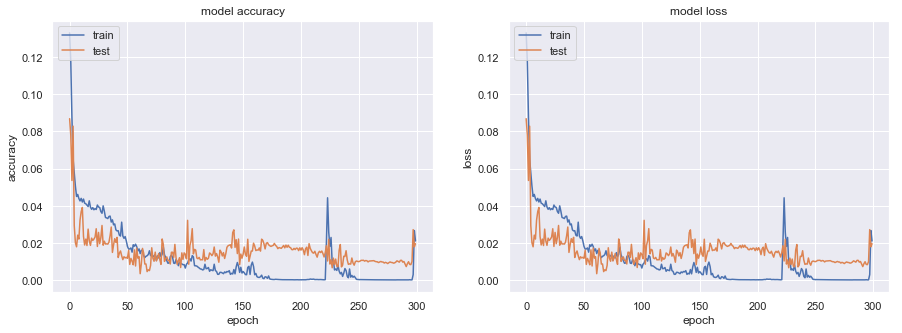

In [16]:
network_plot(history)

In [17]:
predictions = network_predict(cnn, np.expand_dims(ds.X_test, axis=2), ds.y_test)
comparison = np.concatenate((predictions, np.expand_dims(ds.y_test, axis=1)), axis=1)

In [18]:
np.set_printoptions(suppress=True)
comparison

array([[-0.024     , -0.003     ],
       [-0.022     ,  0.018     ],
       [-0.025     , -0.002     ],
       [-0.025     , -0.002     ],
       [-0.007     ,  0.073     ],
       [-0.03      , -0.        ],
       [-0.028     , -0.        ],
       [-0.098     , -0.098     ],
       [-0.016     , -0.002     ],
       [-0.026     , -0.001     ],
       [-0.87300003, -1.        ],
       [-0.027     ,  0.033     ],
       [-0.026     ,  0.        ],
       [-0.018     ,  0.001     ],
       [-0.012     , -0.005     ],
       [-0.03      , -0.001     ],
       [-0.036     , -0.002     ],
       [-0.026     , -0.037     ],
       [-0.021     ,  0.035     ],
       [-0.021     , -0.        ],
       [-0.026     , -0.006     ],
       [-0.042     , -0.09      ],
       [ 0.016     ,  0.038     ],
       [-0.95499998, -0.004     ],
       [-0.028     ,  0.        ],
       [-0.027     , -0.002     ],
       [-0.072     , -0.101     ],
       [-0.041     ,  0.005     ],
       [-0.035     ,

In [19]:
cnn.save("../cnn4.h5")

In [20]:
0.0005

0.0005